Imports

In [1]:
import joblib
import numpy as np
import pandas as pd
from config import *
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

Preparacion del conjunto de datos

In [2]:
data = pd.read_csv(formated_train)

features = ['terrenoEdificado', 'coordX', 'coordY', 'barrioID', 'ano', 'mes', 'dia']
data_for_clustering = data[features]

scaler_kmeans = StandardScaler()
scaled_data = scaler_kmeans.fit_transform(data_for_clustering)

kmeans = joblib.load(kmeans_model)
data['clusterKM'] = kmeans.predict(scaled_data)

Modelo ensamblado inicial

In [5]:
ensamble = joblib.load(ensamble_precio_model)

features = ['terrenoEdificado', 'comisariaCercana', 'transporteCercano', 
                'saludCercana', 'coordX', 'coordY', 'clusterKM', 'barrioID', 
                'ano', 'mes', 'dia']
data_for_train = data[features]
target_column = 'precioUSD'
target = data[target_column]

scaler_ensamble = StandardScaler()
scaled_data = scaler_ensamble.fit_transform(data_for_train)

X_train, X_test, y_train, y_test = train_test_split(data_for_train, target, train_size=0.99, random_state=33)

X_test_scaled = scaler_ensamble.transform(X_test)
all_data_predictions = ensamble.predict(X_test_scaled)

ensemble_r2 = r2_score(y_test, all_data_predictions)
ensemble_rmse = np.sqrt(mean_squared_error(y_test, all_data_predictions))

print(f'Ensamble R2: {ensemble_r2}')
print(f'Ensamble RMSE: {ensemble_rmse}')

Ensamble R2: 0.662764099918681
Ensamble RMSE: 52342.48836858413


Confección del modelo de correccion

In [6]:
residuals = y_test - all_data_predictions

residual_boosting_model = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=5, criterion='absolute_error'), n_estimators=50, random_state=42)
residual_boosting_model.fit(X_test, residuals)

residual_pred_ada = residual_boosting_model.predict(X_test)
final_predictions = all_data_predictions + residual_pred_ada

r2 = r2_score(y_test, final_predictions)
rmse = np.sqrt(mean_squared_error(y_test, final_predictions))

print(f"R^2 para el modelo ensamblado corregido con residuos de boosting: {r2}")
print(f"RMSE del modelo ensamblado corregido con residuos de boosting: {rmse}")

R^2 para el modelo ensamblado corregido con residuos de boosting: 0.9823391587449601
RMSE del modelo ensamblado corregido con residuos de boosting: 11978.244075523457


c:\Users\benja\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Predicciones

In [7]:
# Choose random sample of 100 data points
random_sample = np.random.choice(data.index, size=100, replace=False)

In [58]:
# Predecir el precio de 100 casas con fecha de actualizacion 2023-01-01
samples = data.iloc[random_sample].copy()
samples.drop(columns=["clusterKM"], inplace=True)

samples["fechaReal"] = samples.apply(lambda x: f"{x['ano']}-{x['mes']}-{x['dia']}", axis=1)

Prediccion 1/12

In [59]:
features = ['terrenoEdificado', 'coordX', 'coordY', 'barrioID', 'ano', 'mes', 'dia']
data_for_clustering = samples[features]
data_for_clustering.loc[:, "mes"] = 12
data_for_clustering.loc[:, "dia"] = 1
scaled_data = scaler_kmeans.fit_transform(data_for_clustering)

samples['clusterKM'] = kmeans.predict(scaled_data)

features = ['terrenoEdificado', 'comisariaCercana', 'transporteCercano', 
                'saludCercana', 'coordX', 'coordY', 'clusterKM', 'barrioID', 
                'ano', 'mes', 'dia']

samples_features = samples[features]
samples_features.loc[:, "mes"] = 12
samples_features.loc[:, "dia"] = 1

scaled_data = scaler_ensamble.fit_transform(samples_features)

predictions = ensamble.predict(scaled_data)
residuals = residual_boosting_model.predict(samples_features)

final_predictions = predictions + residuals

samples.loc[:, "prediccion_1-12"] = predictions
samples.loc[:, "prediccion_corregida_1-12"] = final_predictions

Prediccion 15/12

In [60]:
features = ['terrenoEdificado', 'coordX', 'coordY', 'barrioID', 'ano', 'mes', 'dia']
data_for_clustering = samples[features]
data_for_clustering.loc[:, "mes"] = 12
data_for_clustering.loc[:, "dia"] = 15
scaled_data = scaler_kmeans.fit_transform(data_for_clustering)

samples['clusterKM'] = kmeans.predict(scaled_data)

features = ['terrenoEdificado', 'comisariaCercana', 'transporteCercano', 
                'saludCercana', 'coordX', 'coordY', 'clusterKM', 'barrioID', 
                'ano', 'mes', 'dia']

samples_features = samples[features]
samples_features.loc[:, "mes"] = 12
samples_features.loc[:, "dia"] = 15

scaled_data = scaler_ensamble.fit_transform(samples_features)

predictions = ensamble.predict(scaled_data)
residuals = residual_boosting_model.predict(samples_features)

final_predictions = predictions + residuals

samples.loc[:, "prediccion_15-12"] = predictions
samples.loc[:, "prediccion_corregida_15-12"] = final_predictions

In [61]:
samples.columns

Index(['precioUSD', 'terrenoTotal', 'terrenoEdificado', 'barrio', 'coordX',
       'coordY', 'vendedor', 'comisariaCercana', 'transporteCercano',
       'saludCercana', 'distanciaCentro', 'barrioID', 'ano', 'mes', 'dia',
       'fechaReal', 'clusterKM', 'prediccion_1-12',
       'prediccion_corregida_1-12', 'prediccion_15-12',
       'prediccion_corregida_15-12'],
      dtype='object')

In [62]:
samples.drop(columns=["clusterKM", 'terrenoTotal', 'ano', 'mes', 'dia'], inplace=True)

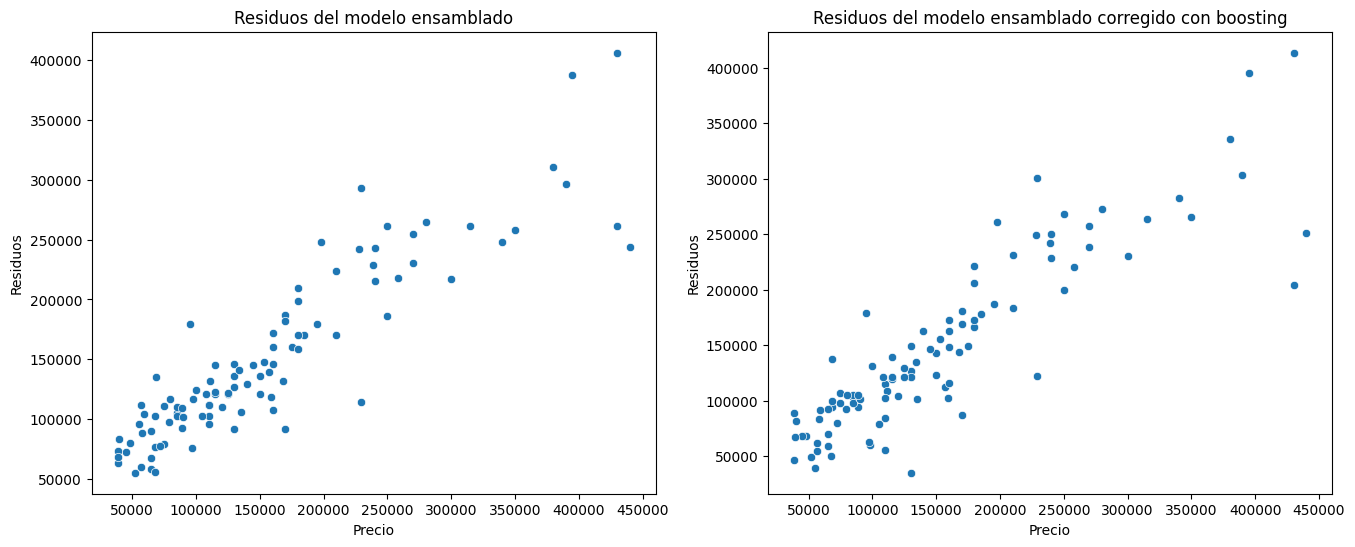

R2 y RMSE de cada prediccion
Prediccion 1-12
R2: 0.7913524169351447
RMSE: 43956.109551535286
Prediccion corregida 1-12
R2: 0.775426046049495
RMSE: 45602.878924453704


In [63]:
# Plot residuals
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.scatterplot(x=samples["precioUSD"], y=samples["prediccion_1-12"], ax=ax[0])
sns.scatterplot(x=samples["precioUSD"], y=samples["prediccion_corregida_1-12"], ax=ax[1])
ax[0].set_title("Residuos del modelo ensamblado")
ax[1].set_title("Residuos del modelo ensamblado corregido con boosting")
ax[0].set_ylabel("Residuos")
ax[1].set_ylabel("Residuos")
ax[0].set_xlabel("Precio")
ax[1].set_xlabel("Precio")
plt.show()

# print r2 and rmse de cada prediccion
print("R2 y RMSE de cada prediccion")
print("Prediccion 1-12")
print(f"R2: {r2_score(samples['precioUSD'], samples['prediccion_1-12'])}")
print(f"RMSE: {np.sqrt(mean_squared_error(samples['precioUSD'], samples['prediccion_1-12']))}")

print("Prediccion corregida 1-12")
print(f"R2: {r2_score(samples['precioUSD'], samples['prediccion_corregida_1-12'])}")
print(f"RMSE: {np.sqrt(mean_squared_error(samples['precioUSD'], samples['prediccion_corregida_1-12']))}")


In [64]:
# linear regression correction
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(samples[["prediccion_1-12"]], samples["precioUSD"])
lr_pred = lr.predict(samples[["prediccion_1-12"]])
lr_r2 = r2_score(samples["precioUSD"], lr_pred)
lr_rmse = np.sqrt(mean_squared_error(samples["precioUSD"], lr_pred))

print(f"R2 del modelo lineal: {lr_r2}")
print(f"RMSE del modelo lineal: {lr_rmse}")

samples.loc[:, "prediccion_corregida_lineal_1-12"] = lr_pred

R2 del modelo lineal: 0.8195125868391684
RMSE del modelo lineal: 40882.366588062534


In [65]:
# linear regression correction
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(samples[["prediccion_15-12"]], samples["precioUSD"])
lr_pred = lr.predict(samples[["prediccion_15-12"]])
lr_r2 = r2_score(samples["precioUSD"], lr_pred)
lr_rmse = np.sqrt(mean_squared_error(samples["precioUSD"], lr_pred))

print(f"R2 del modelo lineal: {lr_r2}")
print(f"RMSE del modelo lineal: {lr_rmse}")

samples.loc[:, "prediccion_corregida_lineal_15-12"] = lr_pred


R2 del modelo lineal: 0.8195125868391684
RMSE del modelo lineal: 40882.366588062534


In [67]:
samples.to_csv("preds.csv")